# Requirements

In [1]:
import collections
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)
import numpy as np
import pandas as pd
import pathlib
import pickle
import random
import sys
#import xgboost as xgb

2023-01-25 13:29:09,447 : INFO : NumExpr defaulting to 8 threads.


In [2]:
sys.path.append('lib')

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import preprocessing

# Data preparation

As usual, we need a function to split the data into a training and a test set.  Since this is just an experiment, we split unstratified.

In [6]:

def split_data(directory, file_pattern, test_fraction=0.2):
    print("Bollocks")
    train_data, test_data = [], []
    for tag, file in enumerate(directory.glob(file_pattern)):
        print(tag)
        text = open(file, 'r').read().split()
        if random.random() < test_fraction:
            test_data.append(text)
        else:
            document = gensim.models.doc2vec.TaggedDocument(text, [tag])
            train_data.append(document)
    return train_data, test_data

In [8]:
print("jklf")
input_dir = pathlib.Path('data/2-papers-text/')
train_data, test_data = split_data(input_dir, 'processed_*.txt')

jklf
Bollocks


In [4]:
len(train_data), len(test_data)

(603, 145)

# Model training

Documents are quite long, so we choose a vector representation of 50 elements, and a minimum word count of 4.  We train for 40 epochs.

In [5]:
model = gensim.models.doc2vec.Doc2Vec(
    vector_size=50,
    min_count=4,
    epochs=40
)

2023-01-10 14:53:59,446 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d50,n5,w5,mc4,s0.001,t3>', 'datetime': '2023-01-10T14:53:59.446469', 'gensim': '4.3.0', 'python': '3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]', 'platform': 'Linux-5.15.79.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'created'}


We build the vocabulary of the model.

In [6]:
model.build_vocab(train_data)

2023-01-10 14:54:03,480 : INFO : collecting all words and their counts
2023-01-10 14:54:03,483 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2023-01-10 14:54:03,951 : WARNING : Highest int doctag (747) larger than count of documents (603). This means at least 144 excess, unused slots (28800 bytes) will be allocated for vectors.
2023-01-10 14:54:03,952 : INFO : collected 63879 word types and 748 unique tags from a corpus of 603 examples and 4943092 words
2023-01-10 14:54:03,952 : INFO : Creating a fresh vocabulary
2023-01-10 14:54:04,029 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=4 retains 23945 unique words (37.48% of original 63879, drops 39934)', 'datetime': '2023-01-10T14:54:04.029692', 'gensim': '4.3.0', 'python': '3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]', 'platform': 'Linux-5.15.79.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
2023-01-10 14:54:04,030 : INF

We train the model on the training data.

In [7]:
model.train(train_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

2023-01-10 14:54:06,126 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 23945 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2023-01-10T14:54:06.126092', 'gensim': '4.3.0', 'python': '3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]', 'platform': 'Linux-5.15.79.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'train'}
2023-01-10 14:54:07,133 : INFO : EPOCH 0 - PROGRESS: at 71.97% examples, 2422533 words/s, in_qsize 5, out_qsize 0
2023-01-10 14:54:07,487 : INFO : EPOCH 0: training on 4943092 raw words (3319262 effective words) took 1.4s, 2446433 effective words/s
2023-01-10 14:54:08,495 : INFO : EPOCH 1 - PROGRESS: at 69.32% examples, 2350114 words/s, in_qsize 5, out_qsize 0
2023-01-10 14:54:08,903 : INFO : EPOCH 1: training on 4943092 raw words (3318896 effective words) took 1.4s, 2349733 effective words/s
2023-01-10 14:54:09,909 : INFO : EPOCH 2 - PROGRESS

Save the model to a file for later usage.

In [8]:
with open('data/doc2vec_model.pickle', 'wb') as file:
    pickle.dump(model, file)

# Evaluation

In [ ]:
with open('data/doc2vec_model.pickle', 'rb') as file:
    model = pickle.load(file)

To evaluate the model, we compute the inferred vector for each document, and based on that retrieve the most similar documents ranked by similarity.  The model can be considered sane if the document is most similar to itself.

Note that overfitting is a risk here.

In [9]:
ranks = []
second_ranks = []
for doc_nr in range(len(train_data)):
    inferred_vector = model.infer_vector(train_data[doc_nr].words)
    doc_id = train_data[doc_nr].tags[0]
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

In [10]:
counter = collections.Counter(ranks)
for rank in sorted(counter.keys()):
    print(f'{rank:3d}: {counter[rank]:3d}')

  0: 595
  1:   6
  2:   2


It is clear that the model performs well on the training data.

# Document vectors

The document vectors will serve as input for classification tasks, so we generate the vector for each documents.

In [12]:
output_dir = pathlib.Path('data/7-doc-vectors')
if not output_dir.exists():
    output_dir.mkdir()

In [17]:
input_dir = pathlib.Path('data/2-papers-text/')
for file in input_dir.glob('processed_*.txt'):
    text = open(file, 'r').read().split()
    doc_vector = model.infer_vector(text)
    with open(output_dir / file.name.replace('processed_', ''), 'w') as out_file:
        np.savetxt(out_file, doc_vector)

In [24]:
nr_files = len(list(output_dir.glob('*.txt')))

In [26]:
doc_vectors = np.empty((nr_files, model.vector_size))
for i, file in enumerate(sorted(output_dir.glob('*.txt'))):
    doc_vectors[i, :] = np.genfromtxt(file)
np.savetxt('data/doc2vec_vectors.txt', doc_vectors)

# Meta data

In [30]:
doc_vectors = np.genfromtxt('data/doc2vec_vectors.txt')

In [22]:
metadata = pd.read_csv('data/metadata.csv')

In [42]:
q1_train_data, q1_val_data, q1_test_data = preprocessing.create_datasets(doc_vectors, metadata, 'QuestionID', 1)

In [43]:
evallist = [(q1_train_data, 'train'), (q1_val_data, 'eval')]

A number of hyperparameters can be specified.
* `max_depth`: increases model complexity, hence potential overfitting.
* `eta`: determines step size, when decreased, increase number of steps.
* `nthread': number of threads to use for the learning process.
* `eval_metric`: metric used to evaluate training and validation sets.

In [44]:
param = {
    'max_depth': 2,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc',
}
nr_steps = 100

In order to keep track of the training and validation error, we can define a dictionary to hold that information.

In [45]:
progress = {}

Train the model.

In [46]:
bst = xgb.train(param, q1_train_data, nr_steps, evals_result=progress, evals=evallist)

[0]	train-auc:0.85767	eval-auc:0.79015
[1]	train-auc:0.90180	eval-auc:0.88460
[2]	train-auc:0.90198	eval-auc:0.88460
[3]	train-auc:0.90204	eval-auc:0.88460
[4]	train-auc:0.90725	eval-auc:0.88662
[5]	train-auc:0.93196	eval-auc:0.90732
[6]	train-auc:0.95306	eval-auc:0.90177
[7]	train-auc:0.95318	eval-auc:0.90227
[8]	train-auc:0.95663	eval-auc:0.91818
[9]	train-auc:0.95857	eval-auc:0.91692
[10]	train-auc:0.95937	eval-auc:0.91591
[11]	train-auc:0.95919	eval-auc:0.91591
[12]	train-auc:0.96204	eval-auc:0.91692
[13]	train-auc:0.97009	eval-auc:0.93232
[14]	train-auc:0.97497	eval-auc:0.93207
[15]	train-auc:0.97497	eval-auc:0.93106
[16]	train-auc:0.97440	eval-auc:0.94419
[17]	train-auc:0.97527	eval-auc:0.94520
[18]	train-auc:0.97627	eval-auc:0.94621
[19]	train-auc:0.97622	eval-auc:0.94722
[20]	train-auc:0.97598	eval-auc:0.95126
[21]	train-auc:0.97622	eval-auc:0.95252
[22]	train-auc:0.97667	eval-auc:0.95480
[23]	train-auc:0.97671	eval-auc:0.95505
[24]	train-auc:0.98053	eval-auc:0.95454
[25]	train

In [57]:
def save_progress(progress, file_name):
    train_progress = progress['train']['auc']
    eval_progress = progress['eval']['auc']
    time_progress = range(1, len(train_progress) + 1)
    progress_data = np.array([time_progress, train_progress, eval_progress]).transpose()
    np.savetxt(file_name, progress_data)

Now the trained model can be used to predict whether a document answers the question, and we can compare this to the output for the test data.

In [47]:
q1_pred_output = bst.predict(q1_test_data)

In [49]:
q1_test_output = np.genfromtxt('data/6-validations/QuestionID_1_target_output.txt')

In [50]:
np.count_nonzero(q1_test_output - q1_pred_output.round(0))/len(q1_test_output)

0.040268456375838924

In [53]:
param = {
    'max_depth': 2,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc',
    'verbosity': 0,
}
nr_steps = 100

In [58]:
for question_id in metadata.QuestionID.unique():
    preprocessing.train_eval(doc_vectors, metadata,
                             'QuestionID', question_id,
                             param, nr_steps, verbose=False)

In [60]:
for pillar_id in metadata.PillarID.unique():
    preprocessing.train_eval(doc_vectors, metadata,
                             'PillarID', pillar_id,
                             param, nr_steps)

In [61]:
for subquestion_id in metadata.SubQuestionID.unique():
    preprocessing.train_eval(doc_vectors, metadata,
                             'SubQuestionID', subquestion_id,
                             param, nr_steps)

In [63]:
with open('data/6-validations/test_questions_score.txt', 'w') as file:
    print('question_id,score', file=file)
    for question_id in sorted(metadata.QuestionID.unique()):
        print(f"{question_id:3d},{preprocessing.evaluate('QuestionID', question_id):.3f}", file=file)

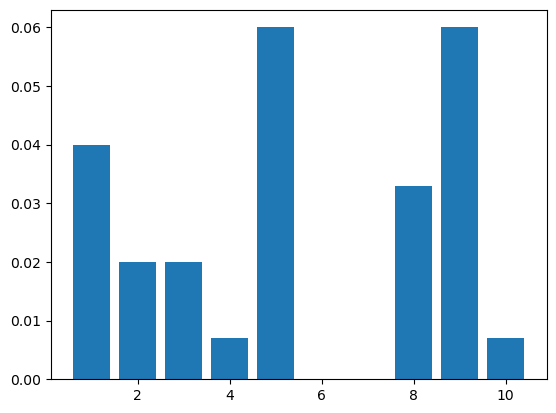

In [65]:
preprocessing.plot_score('data/6-validations/test_questions_score.txt')

In [66]:
with open('data/6-validations/test_pillars_score.txt', 'w') as file:
    print('pillar_id,score', file=file)
    for pillar_id in sorted(metadata.PillarID.unique()):
        print(f"{pillar_id:3d},{preprocessing.evaluate('PillarID', pillar_id):.3f}", file=file)

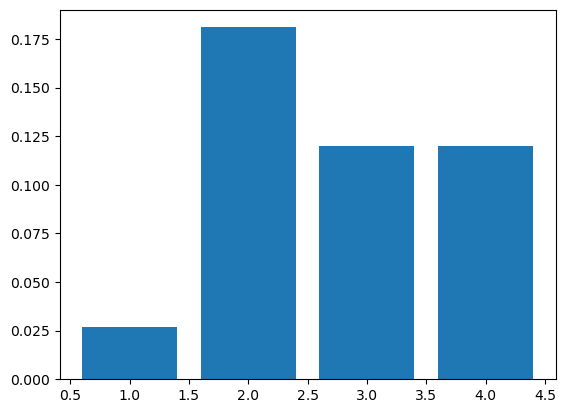

In [68]:
preprocessing.plot_score('data/6-validations/test_pillars_score.txt')